# Taller de Procesamiento de Lenguaje Natural: Recuperación de Información Aplicada a Entrevistas y Libros de la Comisión de la Verdad

**Autores**  
- **Juan Aponte Duque**  
  Pontificia Universidad Javeriana  
  [aponte.juan@javeriana.edu.co](mailto:aponte.juan@javeriana.edu.co)

- **Cristian Cardozo Amin**  
  Pontificia Universidad Javeriana  
  [cristiancardozo@javeriana.edu.co](mailto:cristiancardozo@javeriana.edu.co)

- **Benkos Triana Ocampo**  
  Pontificia Universidad Javeriana  
  [b.triana@javeriana.edu.co](mailto:b.triana@javeriana.edu.co)


## Objetivo 
Desarrollar  un  proceso  de  Recuperación  de  Información  (IR)  para  determinar  qué entrevistas  contenidas  en  el  documento  JSON  están  relacionadas  con testimonios  o  secciones de los libros de la Comisión de la Verdad (CEV). Se espera que los estudiantes  apliquen técnicas de procesamiento de lenguaje natural para analizar y  relacionar  las narraciones  de  entrevistas  con  textos  específicos  de  los  libros,  utilizando  métricas específicas para medir la relevancia de los resultados.

## Recursos:
- **Libros de la Comisión de la Verdad (CEV)**:

[https://drive.google.com/drive/folders/1W9UOdkqnAcztnFZ8xresW4ZeZ2pqXe4v?usp=sharing]
- **Entrevistas**:

[https://drive.google.com/file/d/1XeFS_mQFmTLQ_VUiODTBO5eONWv-Ege5/view?usp=sharing]

- **Tesauro CEV**:

[https://drive.google.com/file/d/1XgZzMtFQp0RzwqdY7Em5q5ProsWLMMX4/view?usp=sharing]

---
---
## Dependecias

In [1]:
import pandas as pd
import sys
from pandarallel import pandarallel

# Inicializar pandarallel
pandarallel.initialize(progress_bar=True)
sys.path.append("../src")
from funciones_nlp import *
from funciones_pdf import *
from funciones_json import *
from funciones_abt import *

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


---
---
## Extracción y Preparación del Corpus

### Extraer las secciones, testimonios o partes relevantes de cada uno de los libros de la CEV.

#### Extraccion Libro "MI CUERPO ES LA VERDAD"

In [2]:
# Ruta del archivo PDF del libro de la CEV
pdf_path = "../data/input/CEV_MI CUERPO ES LA VERDAD_DIGITAL_2022.pdf"

# Página inicial para comenzar la extracción 
START_AFTER_PAGE_1BASED = 37  

# Definición de la estructura del libro para la extracción
schema = {
    "Mujeres": {
        "¿Qué pasó? Significados y  magnitudes de lo sucedido": [
            "La guerra, el territorio y las mujeres",
            "Las violencias sexuales y reproductivas contra niñas y mujeres",
            "Mujeres políticas expulsadas de la democracia",
            "Las mujeres en la guerra: vinculación e impactos en sus vidas y en sus familias",
        ],
        "¿Por qué pasó? Dimensiones del patriarcado": [
            "El contínuum de violencias, una realidad que cambia pero no desaparece",
            "El mandato de las masculinidades guerreras y su relación con el militarismo",
            "La desprotección por parte del Estado en zonas de conflicto",
        ],
        "¿Qué pasó con lo que pasó?": [
            "Impactos del conflicto armado en las mujeres",
            "Afrontamientos de las mujeres víctimas",
            "Resistencias, juntanza y organización: en las mujeres reposa la fuerza de la comunidad",
        ],
        "_end_before": "Epílogo",
        "_boundaries": [
            "¿Por qué pasó? Dimensiones del patriarcado",
            "¿Qué pasó con lo que pasó?",
        ],
    },
    "LGBTIQ+": {
        "¿Qué pasó? Violencias contra las personas LGBTIQ+ en el marco del conflicto armado colombiano": [
            "Una mirada general a las violencias contra las personas LGBTIQ+ en la guerra",
            "Situaciones territoriales ilustrativas de la persecución contra personas LGBTIQ+ en el marco del conflicto armado",
            "La persecución contra personas LGBTIQ+ en el conflicto armado colombiano",
            "Patrones de persecución contra las personas LGBTIQ+ diferenciados según el actor armado",
            "Otras consideraciones",
        ],
        "Los porqués de la persecución contra personas LGBTIQ+": [
            "La herencia colonial como un factor histórico explicativo",
            "Factores socioculturales",
            "Factores institucionales y políticos",
        ],
        "¿Qué pasó con lo que les pasó a las personas LGBTIQ+ en el marco del conflicto armado colombiano?": [
            "Impactos de las violencias contra personas LGBTIQ+",
            "Afrontamientos de personas LGBTIQ+ víctimas del conflicto armado en Colombia",
            "Cuerpos disidentes que resisten y transforman para la paz",
        ],
        "_end_before": "Conclusiones",
        "_boundaries": [
            "Los porqués de la persecución contra personas LGBTIQ+",
            "¿Qué pasó con lo que les pasó a las personas LGBTIQ+ en el marco del conflicto armado colombiano?",
        ],
    },
}

# Función para extraer el DataFrame del PDF según el esquema definido
df_result = extract_dataframe_from_pdf(pdf_path, START_AFTER_PAGE_1BASED, schema, drop_empty=False)
print(df_result.shape)
df_result.head(3)

(21, 4)


,seccion,seccion_principal,subseccion,contenido
0,Mujeres,¿Qué pasó? Significados y magnitudes de lo su...,"La guerra, el territorio y las mujeres",Las mujeres viven la guerra en sus territorios...
1,Mujeres,¿Qué pasó? Significados y magnitudes de lo su...,Las violencias sexuales y reproductivas contra...,Duele la lengua rota. \n¿Dónde está mi femenin...
2,Mujeres,¿Qué pasó? Significados y magnitudes de lo su...,Mujeres políticas expulsadas de la democracia,».\n\n¿qué pasó? significados y magnitudes de ...


#### Extraccion entrevistas de la comision de la verdad

In [3]:
json_path = "../data/input/entrevistas_all_2023-03-21_14-24_05.json"  
columna = 'text'
workers = 6

df_testimonios = procesar_json(json_path, columna, workers)

print(df_testimonios.shape)
df_testimonios.head(3)

Entrevistas vacías detectadas: 2
Se encontraron 268 entrevistas duplicadas.
(2216, 4)


,id_doc,pages,text,text_clean
0,5eb4e7bfda6da3b502da3589.pdf,30,001-VI-00008\nTEST: Bajo la apariencia de una...,"bajo la apariencia de una democracia formal , ..."
1,5eb4e7c1da6da3b502da3593.pdf,15,"ENT:\nBueno, hoy es --------------------------...","bueno , hoy es y vamos a empezar la entrevista..."
2,5eb4e7c1da6da3b502da3595.pdf,38,001-VI-00011\n \n001-VI-00011_(48057): 01:30:...,"merci , merci . bueno , buenas tardes , buenas..."


### Definir la morfología de documento para recuperar

#### Morfología del libro "MI CUERPO ES LA VERDAD"

In [4]:
contenido_mi_verdad = " ".join(df_result["contenido"].astype(str))
print(contenido_mi_verdad[:500])

Las mujeres viven la guerra en sus territorios, en su vida y en su cuerpo. Esto es verdad 
para cualquier persona que haya sido afectada por el conflicto. Sin embargo, la relación 
de las mujeres con el territorio y con la guerra es diferente de la que viven los hombres, 
o los niños, o cualquier otro grupo poblacional. Las mujeres en los territorios son las 
encargadas de las labores de reproducción y de cuidado del hogar, la familia, lo comunitario y lo social; por ello, suelen permanecer en l


In [5]:
morfologia_texto(contenido_mi_verdad)

{'original': {'oraciones': 6633,
  'cantidad_palabras': 142272,
  'cantidad_palabras_sin_stopwords': 59550,
  'promedio_palabras_por_oracion': 21.44911804613297,
  'promedio_verbos_por_oracion': 3.103271521181969,
  'promedio_sustantivos_por_oracion': 5.7975275139454245,
  'promedio_adjetivos_por_oracion': 1.4483642394090155,
  'promedio_pronombres_por_oracion': 1.8309965324890698,
  'promedio_adverbios_por_oracion': 0.8181818181818182,
  'promedio_stopwords_por_oracion': 12.471279963817278,
  'total_verbos': 20584,
  'total_sustantivos': 38455,
  'total_adjetivos': 9607,
  'total_pronombres': 12145,
  'total_adverbios': 5427,
  'total_stopwords': 82722},
 'sin_stopwords': {'oraciones': 6633,
  'cantidad_palabras': 59550,
  'cantidad_palabras_sin_stopwords': 59550,
  'promedio_palabras_por_oracion': 8.977838082315694,
  'promedio_verbos_por_oracion': 2.052314186642545,
  'promedio_sustantivos_por_oracion': 5.443992160410071,
  'promedio_adjetivos_por_oracion': 1.3259460274385648,
  'pr

#### Textometría del libro "Mi cuerpo es la verdad"

In [5]:
print_indices_es(contenido_mi_verdad)

=== ÍNDICES DE LEGIBILIDAD (ES) ===
Fernández Huerta: 84.14
Szigriszt-Pazos (INFLESZ): 80.71
Gutiérrez de Polini: 40.22
Flesch Reading Ease (referencial): 42.96


#### Morfología testimonios

In [6]:
contenido_testimonios = " ".join(df_testimonios["text_clean"].astype(str))
print(contenido_testimonios[:1000])

bajo la apariencia de una democracia formal , en colombia se vivía un régimen de terror : servicios de inteligencia estatales ¿ estamos hablando ... ? ¿ a partir de qué época estamos hablando ? estamos hablando ya a partir de 1985 . entonces , te decía que servicios de inteligencia oficiales , estructuras de las fuerzas militares y de policía y del organización pública 1 se entrelazaban con grupos paramilitares de extrema derecha en desarrollo de una estrategia de contrainsurgencia aparejada con una guerra sucia de liquidación y exterminio del movimiento popular colombiano , del que fueron víctimas opositores políticos , sociales y de consciencia . miles de campesinos de las regiones agrarias , -bajo la influencia del movimiento guerrillero- , miles de sindicalistas , además de defensores de derechos humanos , de jueces de la república que se atrevieron a investigar los crímenes de esa guerra sucia . y , en ese contexto , el genocidio perpetrado contra la unión patriótica , a quien le 

In [18]:
morfologia_texto_high_volume(contenido_testimonios, n_process = 7, batch_size=100, chunk_chars=30_000)

Procesando chunks:   0%|          | 0/5904 [00:00<?, ?chunk/s]

{'original': {'oraciones': 1258731,
  'cantidad_palabras': 31058233,
  'cantidad_palabras_sin_stopwords': 10044839,
  'promedio_palabras_por_oracion': 24.674241756181424,
  'promedio_verbos_por_oracion': 4.835129984087148,
  'promedio_sustantivos_por_oracion': 4.3597941100997755,
  'promedio_adjetivos_por_oracion': 1.1062077600376887,
  'promedio_pronombres_por_oracion': 3.45366007510739,
  'promedio_adverbios_por_oracion': 2.0221731251554145,
  'promedio_stopwords_por_oracion': 16.694110179220182,
  'total_verbos': 6086128,
  'total_sustantivos': 5487808,
  'total_adjetivos': 1392418,
  'total_pronombres': 4347229,
  'total_adverbios': 2545372,
  'total_stopwords': 21013394},
 'sin_stopwords': {'oraciones': 1258731,
  'cantidad_palabras': 10044839,
  'cantidad_palabras_sin_stopwords': 10044839,
  'promedio_palabras_por_oracion': 7.9801315769612415,
  'promedio_verbos_por_oracion': 2.7445157066918986,
  'promedio_sustantivos_por_oracion': 3.9881301088159424,
  'promedio_adjetivos_por_o

#### Textometría de los testimonios

In [ ]:
print_indices_es(contenido_testimoniosFernández Huerta: 91.54
Szigriszt-Pazos (INFLESZ): 88.47
Gutiérrez de Polini: 45.53
Flesch Reading Ease (referencial): 53.99)

=== ÍNDICES DE LEGIBILIDAD (ES) ===
Fernández Huerta: 91.54
Szigriszt-Pazos (INFLESZ): 88.47
Gutiérrez de Polini: 45.53
Flesch Reading Ease (referencial): 53.99


### Preprocesar los textos

#### Preprocesar libro

In [15]:
df_result["contenido_preprocesado"] = df_result["contenido"].parallel_apply(preprocesar_texto)

In [17]:
df_result.head(3)

,seccion,seccion_principal,subseccion,contenido,contenido_preprocesado
0,Mujeres,¿Qué pasó? Significados y magnitudes de lo su...,"La guerra, el territorio y las mujeres",Las mujeres viven la guerra en sus territorios...,"[[mujer, vivir, guerra, territorio, vida, cuer..."
1,Mujeres,¿Qué pasó? Significados y magnitudes de lo su...,Las violencias sexuales y reproductivas contra...,Duele la lengua rota. \n¿Dónde está mi femenin...,"[[doler, lengua, roto], [femenino], [lengua, s..."
2,Mujeres,¿Qué pasó? Significados y magnitudes de lo su...,Mujeres políticas expulsadas de la democracia,».\n\n¿qué pasó? significados y magnitudes de ...,"[[], [pasar, significado, magnitudes, sucedido..."


In [19]:
df_result.to_csv("../data/output/libro_cev_preprocesado.csv", index=False, encoding="utf-8", sep="|")

#### Preprocesar testimonios

In [19]:
df_testimonios["contenido_preprocesado"] = df_testimonios["text_clean"].parallel_apply(preprocesar_texto)

In [20]:
df_testimonios.head(3)

,id_doc,pages,text,text_clean,contenido_preprocesado
0,5eb4e7bfda6da3b502da3589.pdf,30,001-VI-00008\nTEST: Bajo la apariencia de una...,"bajo la apariencia de una democracia formal , ...","[[apariencia, democracia, formal, colombia, vi..."
1,5eb4e7c1da6da3b502da3593.pdf,15,"ENT:\nBueno, hoy es --------------------------...","bueno , hoy es y vamos a empezar la entrevista...","[[empezar, entrevista], [pedir, test, presenta..."
2,5eb4e7c1da6da3b502da3595.pdf,38,001-VI-00011\n \n001-VI-00011_(48057): 01:30:...,"merci , merci . bueno , buenas tardes , buenas...","[[merci, merci], [], [bienvenido, gracias, ven..."


In [22]:
df_testimonios.to_csv("../data/output/testimonios_cev_preprocesado.csv", index=False, encoding="utf-8", sep="|")

----
----
## Análisis Exploratorio del Corpus

In [2]:
# Cargar los datos preprocesados
df_libro = pd.read_csv("../data/output/libro_cev_preprocesado.csv", sep="|", encoding="utf-8")
df_testimonios = pd.read_csv("../data/output/testimonios_cev_preprocesado.csv", sep="|", encoding="utf-8")

### Frecuencia de los terminos

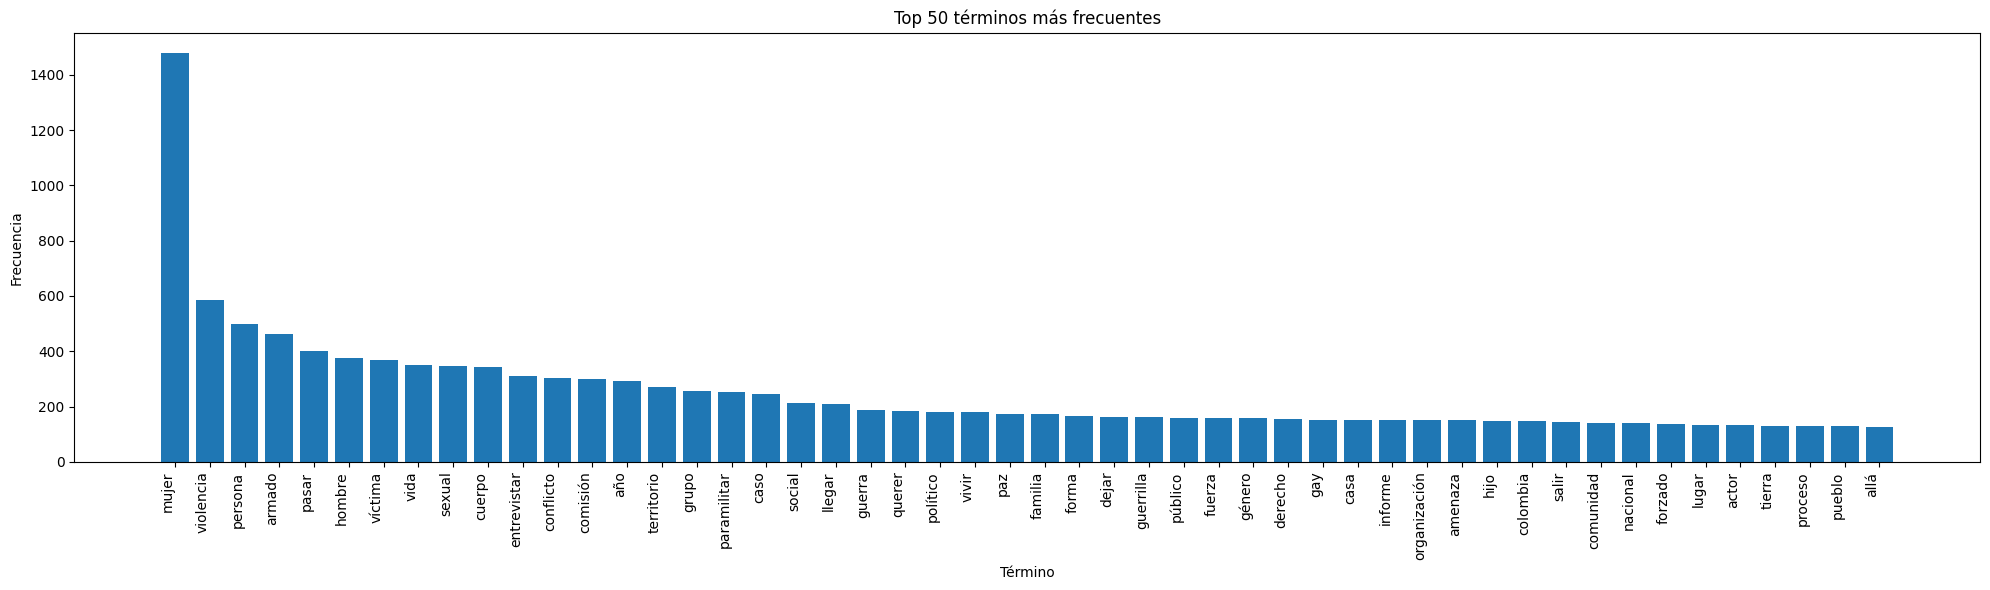

In [3]:
graficar_frecuencias(df_libro, "contenido_preprocesado", top_n=50, min_len=1)

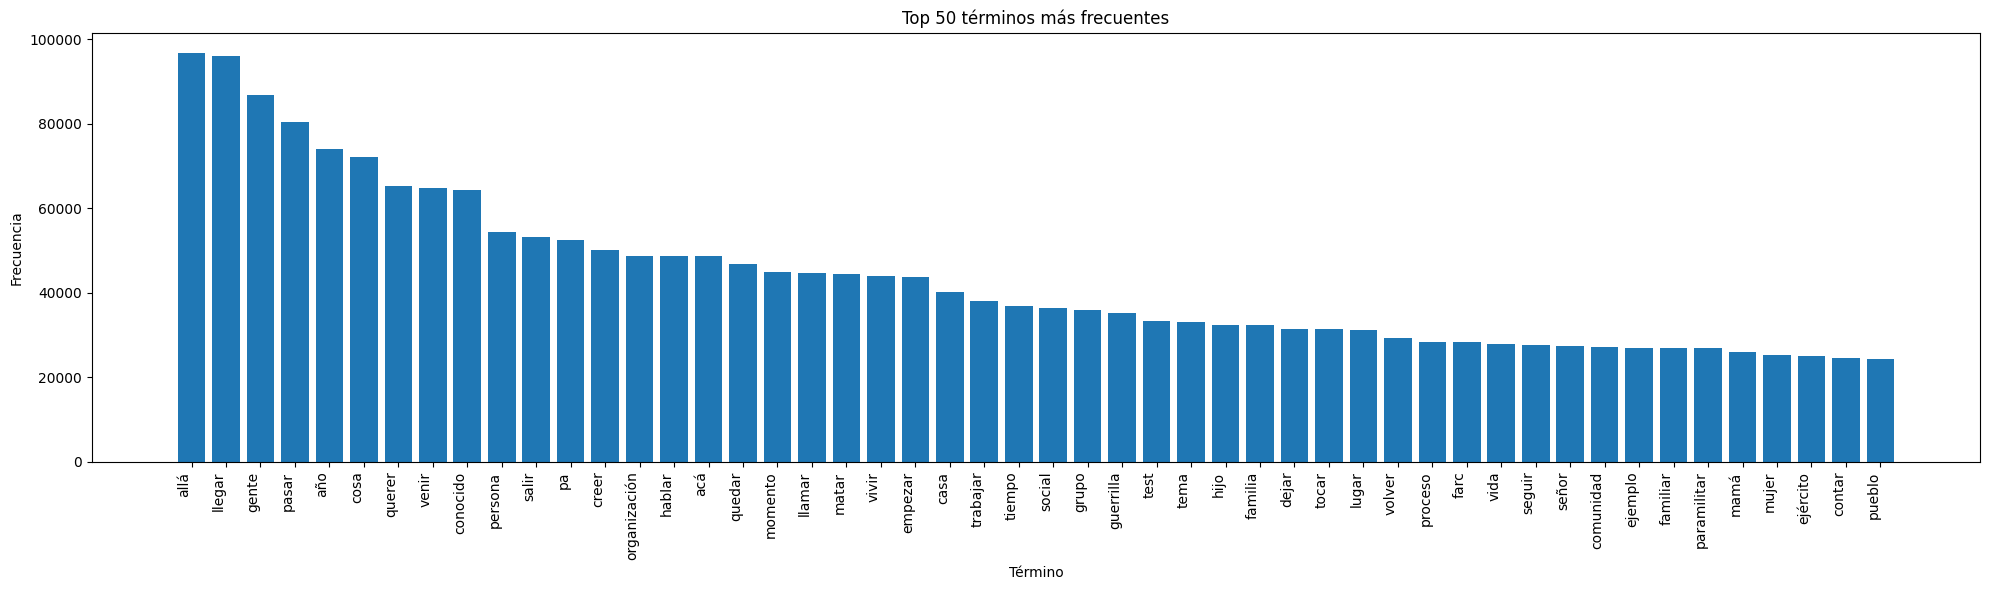

In [4]:
graficar_frecuencias(df_testimonios, "contenido_preprocesado", top_n=50, min_len=1)

### Nube de palabras